In [ ]:
import os
import shutil
import random
import json
import nibabel as nib
from glob import glob

# CONFIGURACIÓN DEL ENTORNO Y RUTAS
# Defino las rutas donde están almacenadas las imágenes (Ajusta si es necesario)
path_origen_images = "/content/imagesTr/imagesTr"
path_origen_labels = "/content/labelsTr/labelsTr"

# Configuro la estructura de destino según el estándar de nnU-Net.
dataset_id = 501
dataset_name = f"Dataset{dataset_id}_BraTS_Subset"
base_nnunet = "/content/nnUNet_raw"

# Construyo las rutas finales
path_destino_root = os.path.join(base_nnunet, dataset_name)
path_destino_images = os.path.join(path_destino_root, "imagesTr")
path_destino_labels = os.path.join(path_destino_root, "labelsTr")

# Establezco el tamaño de la muestra
CANTIDAD_MUESTRA = 250


# MUESTREO Y PROCESAMIENTO (Separación de Canales)
print(f"Iniciando preparación y separación de canales (N={CANTIDAD_MUESTRA})...")

# Crear carpetas
os.makedirs(path_destino_images, exist_ok=True)
os.makedirs(path_destino_labels, exist_ok=True)

# Listar pacientes
pacientes_disponibles = [os.path.basename(x) for x in glob(os.path.join(path_origen_images, "*.nii.gz"))]
print(f"   - Total detectados: {len(pacientes_disponibles)}")

# Selección aleatoria
seleccionados = random.sample(pacientes_disponibles, min(CANTIDAD_MUESTRA, len(pacientes_disponibles)))

print("   - Procesando imágenes...")

for i, f in enumerate(seleccionados):
    # Rutas completas
    src_img_path = os.path.join(path_origen_images, f)
    src_lbl_path = os.path.join(path_origen_labels, f)

    # SEPARAR LA IMAGEN 4D EN 4 ARCHIVOS 3D
    try:
        # Cargar la imagen 4D original
        img_obj = nib.load(src_img_path)
        data = img_obj.get_fdata()      # Los datos numéricos
        affine = img_obj.affine         # La geometría/posición
        header = img_obj.header         # Metadatos

        # El nombre del paciente sin la extensión .nii.gz
        patient_id = f.replace(".nii.gz", "")

        # Bucle para guardar los 4 canales por separado (_0000, _0001, _0002, _0003)
        # Canal 0: T1 | Canal 1: T1ce | Canal 2: T2 | Canal 3: FLAIR
        for canal in range(4):
            # Extraer solo el volumen de ese canal
            if len(data.shape) == 4:
                volumen = data[:, :, :, canal]
            else:
                # Si por error ya fuera 3D, cogemos todo (seguridad)
                volumen = data

            # Crear nuevo objeto Nifti 3D
            new_img = nib.Nifti1Image(volumen, affine, header)

            # Nombre OBLIGATORIO para nnU-Net: ID_0000.nii.gz
            nombre_final = f"{patient_id}_{canal:04d}.nii.gz"
            ruta_guardado = os.path.join(path_destino_images, nombre_final)

            # Guardar
            nib.save(new_img, ruta_guardado)

    except Exception as e:
        print(f" Error procesando imagen {f}: {e}")
        continue

    # COPIAR LABEL
    dst_lbl = os.path.join(path_destino_labels, f)

    if os.path.exists(src_lbl_path):
        shutil.copy(src_lbl_path, dst_lbl)
    else:
        print(f"AVISO: No se encontró etiqueta para {f}")

print(f"Transferencia completada. Imágenes en: {path_destino_images}")

# GENERACIÓN DE dataset.json
print("Generando dataset.json...")

metadatos_dict = {
    "channel_names": {
        "0": "T1",
        "1": "T1ce",
        "2": "T2",
        "3": "FLAIR"
    },
    "labels": {
        "background": 0,
        "edema": 1,
        "non_enhancing": 2,
        "enhancing": 3
    },
    "numTraining": len(seleccionados),
    "file_ending": ".nii.gz",
    "name": dataset_name,
    "reference": "TFM Dataset Subset",
    "release": "1.0",
    "description": "Subconjunto 250 pacientes separados en canales",
}

ruta_json = os.path.join(path_destino_root, "dataset.json")
with open(ruta_json, 'w') as f:
    json.dump(metadatos_dict, f, indent=4)

print(f"Archivo dataset.json generado correctamente.")

## PREPROCESAMIENTO

In [8]:
#Primero instalo nn-Unet en el entorno
!pip install nnunetv2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 kB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.0/77.0 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.7/24.7 MB 114.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 11.0 MB/s eta 0:00:00
  Created wheel for nnunetv2: filename=nnunetv2-2.

In [22]:
import os
# 1. CONFIGURACIÓN DEL ENTORNO DE TRABAJO
# Defino las variables de entorno obligatorias para que nnU-Net localice los datos.
os.environ['nnUNet_raw'] = "/content/nnUNet_raw"
os.environ['nnUNet_preprocessed'] = "/content/nnUNet_preprocessed"
os.environ['nnUNet_results'] = "/content/drive/MyDrive/TRABAJO_FINAL/nnUNet_results"

# 2. EJECUCIÓN DEL PIPELINE DE PREPROCESAMIENTO
print("Iniciando etapa de preprocesamiento...")

# Ejecuto el comando de preprocesamiento estándar.

# El proceso realizará secuencialmente:
# A.Extracción de propiedades biológicas (espaciado de vóxels, tamaños).
# B.Diseño automático de la arquitectura de la red basado en el fingerprint.
# C.Recorte, normalización (z-score) y guardado en formato .npz eficiente.
!nnUNetv2_plan_and_preprocess -d 501 -c 3d_fullres --verify_dataset_integrity

Iniciando etapa de preprocesamiento...
Fingerprint extraction...
Dataset501_BraTS_Subset
Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer

####################
verify_dataset_integrity Done. 
If you didn't see any error messages then your dataset is most likely OK!
####################

Using <class 'nnunetv2.imageio.simpleitk_reader_writer.SimpleITKIO'> as reader/writer
100% 250/250 [00:49<00:00,  5.03it/s]
Experiment planning...

############################
INFO: You are using the old nnU-Net default planner. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Dropping 3d_lowres config because the image size difference to 3d_fullres is too small. 3d_fullres: [138. 169. 138.], 3d_lowres: [138, 169, 138]
2D U-Net configuration:
{'data_identifier': 'nnUNetPlans_2d', 'preprocessor_name': 'DefaultPreprocess

## ENTRENAMIENTO

In [23]:
# Me aseguro de las rutas
os.environ['nnUNet_raw'] = "/content/nnUNet_raw"
os.environ['nnUNet_preprocessed'] = "/content/nnUNet_preprocessed"
os.environ['nnUNet_results'] = "/content/drive/MyDrive/TRABAJO_FINAL/nnUNet_results"

print("Iniciando el entrenamiento del modelo U-Net 3D...")

# EJECUCIÓN DEL ENTRENAMIENTO

# Comando: nnUNetv2_train
# Parámetros seleccionados para el experimento:
# - ID 501: El dataset preprocesado anteriormente.
# - Configuración '3d_fullres': Entrenamos con la resolución espacial completa para maximizar la precisión en la segmentación del tumor.
# - Fold 0: Siguiendo el esquema de validación cruzada (5-fold cross-validation), entreno el primer pliegue (80% training, 20% validation).

!nnUNetv2_train 501 3d_fullres 0

Iniciando el entrenamiento del modelo U-Net 3D...

############################
INFO: You are using the old nnU-Net default plans. We have updated our recommendations. Please consider using those instead! Read more here: https://github.com/MIC-DKFZ/nnUNet/blob/master/documentation/resenc_presets.md
############################

Using device: cuda:0

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

2026-01-14 13:40:48.864895: Using torch.compile...
2026-01-14 13:40:52.132622: do_dummy_2d_data_aug: False
2026-01-14 13:40:52.136194: Creating new 5-fold cross-validation split...
2026-01-14 13:40:52.140746: Desired fold for training: 0
2026-01-

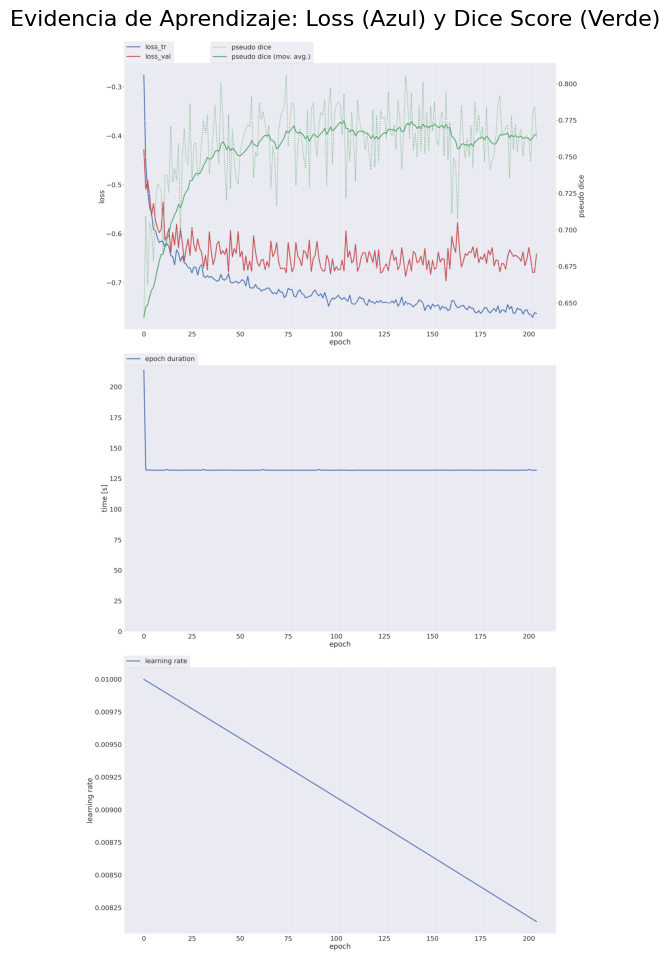

In [26]:
# VERIFICAR QUE EL MODELO HA APRENDIDO

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

# Defino la ruta del gráfico de progreso generado por nnU-Net.
ruta_grafica = "/content/drive/MyDrive/TRABAJO_FINAL/nnUNet_results/Dataset501_*/nnUNetTrainer__nnUNetPlans__3d_fullres/fold_0/progress.png"

# Ejecuto la búsqueda del archivo en el sistema de archivos de Drive.
archivos = glob(ruta_grafica)

if archivos:
    # Cargo la imagen del gráfico de progreso en memoria.
    img = mpimg.imread(archivos[0])

    # Configuro el tamaño de la figura.
    plt.figure(figsize=(18, 12))
    plt.imshow(img)

    # Elimino los ejes de coordenadas.
    plt.axis('off')

    plt.title("Evidencia de Aprendizaje: Loss (Azul) y Dice Score (Verde)", fontsize=16)
    plt.show()


else:
    print("No se encuentra la gráfica.")

In [29]:
# PREPARACIÓN DE PACIENTES DE PRUEBA

print("Buscando los pacientes que no se utilizaron en el entrenamiento...")

# CONFIGURACIÓN DE RUTAS
# Defino dónde están mis fuentes de datos y dónde quiero organizar el test set.
path_origen_images = "/content/imagesTr/imagesTr"
path_origen_labels = "/content/labelsTr/labelsTr"
path_train_images = "/content/nnUNet_raw/Dataset501_BraTS_Subset/imagesTr"

# Establezco carpetas de destino claras para el input del modelo y el ground truth (máscaras de segmentacion).
path_test_input = "/content/tests/input"
path_test_truth = "/content/tests/ground_truth"

os.makedirs(path_test_input, exist_ok=True)
os.makedirs(path_test_truth, exist_ok=True)

# Extraigo los IDs únicos del dataset raw para excluir esos pacientes.
archivos_train = os.listdir(path_train_images)
ids_entrenados = set()

for f in archivos_train:
    if f.endswith(".nii.gz"):
        # El formato de nnU-Net es ID_0000.nii.gz.
        # Divido por guiones bajos y elimino el sufijo del canal para recuperar el ID original.
        parts = f.split('_')
        id_clean = "_".join(parts[:-1])
        ids_entrenados.add(id_clean)

print(f"Detectados {len(ids_entrenados)} sujetos ya utilizados.")

# Obtengo los pacientes "nuevos".
todos_origen = glob(os.path.join(path_origen_images, "*.nii.gz"))
pacientes_para_test = []

for p in todos_origen:
    nombre = os.path.basename(p)
    id_paciente = nombre.replace(".nii.gz", "")

    if id_paciente not in ids_entrenados:
        pacientes_para_test.append(p)

print(f" He localizado {len(pacientes_para_test)} sujetos aptos para la validación.")


# Descompongo el dataset original.
print("Descomponiendo canales 4D y organizando archivos...")

for path_img in pacientes_para_test:
    nombre_fichero = os.path.basename(path_img)
    patient_id = nombre_fichero.replace(".nii.gz", "")

    try:
        # Procesamiento de la Imagen: Carga y separación de canales
        img_obj = nib.load(path_img)
        data = img_obj.get_fdata()
        affine = img_obj.affine
        header = img_obj.header

        # Separación y guardado de cada canal por separado
        for canal in range(4):
            if len(data.shape) == 4:
                volumen = data[:, :, :, canal]
            else:
                volumen = data # Si solo hay un canal, no hago nada

            new_img = nib.Nifti1Image(volumen, affine, header)

            # Guardo con la nomenclatura obligatoria: patientID_XXXX.nii.gz
            nombre_final = f"{patient_id}_{canal:04d}.nii.gz"
            nib.save(new_img, os.path.join(path_test_input, nombre_final))

        # Copio la máscara de verdad (ground truth).
        # No lo proceso, solo lo muevo para tenerlo listo al calcular métricas (Dice).
        src_lbl = os.path.join(path_origen_labels, nombre_fichero)
        if os.path.exists(src_lbl):
            shutil.copy(src_lbl, os.path.join(path_test_truth, nombre_fichero))

        # Detengo el bucle si por error solo hubiera una dimensión de canal
        if len(data.shape) < 4: break

    except Exception as e:
        print(f"Error procesando sujeto {patient_id}: {e}")

print(f"\nProceso finalizado. Datos en '{path_test_input}'.")

Buscando los pacientes que no se utilizaron en el entrenamiento...
Detectados 250 sujetos ya utilizados.
 He localizado 234 sujetos aptos para la validación.
Descomponiendo canales 4D y organizando archivos...

Proceso finalizado. Datos en '/content/tests/input'.


In [31]:
# GENERAR PREDICCIONES
import time

# Defino las carpetas de entrada y de salida.
input_folder = "/content/tests/input"
output_folder = "/content/tests/predicciones_finales"
dataset_id = 501

os.makedirs(output_folder, exist_ok=True)

print(f"Iniciando predicción para el dataset {dataset_id}...")

# Registro cuanto tiempo tarda el modelo en hacer la predicción
start_time = time.time()

# Añado '-chk checkpoint_best' para asegurar el uso del modelo de la época 104.
# Uso la configuración '3d_fullres' y el fold 0 siguiendo el esquema de entrenamiento.
!nnUNetv2_predict -i {input_folder} -o {output_folder} -d {dataset_id} -c 3d_fullres -f 0 -chk checkpoint_best.pth

end_time = time.time()
horas = (end_time - start_time) / 3600

print(f"\nPredicciones completadas")
print(f"Tiempo total de procesado: {horas:.2f} horas.")
print(f"Las máscaras generadas están en: {output_folder}")

Iniciando predicción para el dataset 501...

#######################################################################
Please cite the following paper when using nnU-Net:
Isensee, F., Jaeger, P. F., Kohl, S. A., Petersen, J., & Maier-Hein, K. H. (2021). nnU-Net: a self-configuring method for deep learning-based biomedical image segmentation. Nature methods, 18(2), 203-211.
#######################################################################

There are 234 cases in the source folder
I am processing 0 out of 1 (max process ID is 0, we start counting with 0!)
There are 234 cases that I would like to predict

Predicting BRATS_004:
perform_everything_on_device: True
100% 8/8 [00:05<00:00,  1.36it/s]
sending off prediction to background worker for resampling and export
done with BRATS_004

Predicting BRATS_005:
perform_everything_on_device: True
100% 8/8 [00:05<00:00,  1.46it/s]
sending off prediction to background worker for resampling and export
done with BRATS_005

Predicting BRATS_006:


In [34]:
import pandas as pd
import numpy as np

# CÁLCULO MASIVO DE MÉTRICAS (Dice Score)

# Defino las rutas de las carpetas donde están mis resultados y las etiquetas reales.
path_pred = "/content/tests/predicciones_finales"
path_gt = "/content/tests/ground_truth"

# Localizo y ordeno alfabéticamente todos los archivos de predicción para procesarlos en serie.
pred_files = sorted(glob(os.path.join(path_pred, "*.nii.gz")))
resultados = []

def calcular_dice_general(y_true, y_pred):
    """
    He programado esta función para calcular el coeficiente Dice.
    Representa el solapamiento entre la predicción y la máscara real:
    Dice = (2 * Intersección) / (Suma de áreas)
    """
    # Binarizo las máscaras: cualquier valor > 0 se considera "Tumor".
    # Al hacer esto, calculo el volumen total del tumor, junto al edema.
    vol_true = y_true > 0
    vol_pred = y_pred > 0

    # Calculo la intersección (píxeles donde ambos coinciden) y el denominador.
    intersection = np.sum(vol_true * vol_pred)
    denominator = np.sum(vol_true) + np.sum(vol_pred)

    # Si no hay tumor ni predicción, la nota es 1.0 (acierto total).
    if denominator == 0:
        return 1.0 if intersection == 0 else 0.0

    return (2. * intersection) / denominator

# Recorro todos mis archivos de predicción uno por uno.
for p_path in pred_files:
    # Extraigo el ID del paciente para buscar su etiqueta correspondiente.
    pid = os.path.basename(p_path).replace(".nii.gz", "")
    gt_path = os.path.join(path_gt, f"{pid}.nii.gz")

    # Solo calculo la métrica si tengo el archivo de la solución para comparar.
    if os.path.exists(gt_path):
        # Cargo los datos brutos de la predicción y del Ground Truth.
        pred_data = nib.load(p_path).get_fdata()
        gt_data = nib.load(gt_path).get_fdata()

        # Ejecuto mi función de cálculo y almaceno el resultado junto al ID.
        dice = calcular_dice_general(gt_data, pred_data)
        resultados.append({"ID": pid, "Dice_Score": dice})

# Transformo la lista de resultados en un DataFrame de Pandas para poder analizarlo.
df = pd.DataFrame(resultados)

# Exporto todo a un archivo CSV
ruta_csv = "/content/tests/resultados_finales.csv"
df.to_csv(ruta_csv, index=False)

# Imprimo un resumen estadístico rápido en pantalla.
print(f"NOTA MEDIA DEL MODELO: {df['Dice_Score'].mean():.4f}")
print(f"Resumen guardado en: {ruta_csv}")

# Muestro los primeros 10 casos.
print(df.head(10))

NOTA MEDIA DEL MODELO: 0.8997
Resumen guardado en: /content/tests/resultados_finales.csv
          ID  Dice_Score
0  BRATS_004    0.946720
1  BRATS_005    0.821341
2  BRATS_006    0.941951
3  BRATS_007    0.879201
4  BRATS_010    0.855467
5  BRATS_013    0.921303
6  BRATS_014    0.928334
7  BRATS_015    0.943374
8  BRATS_022    0.931579
9  BRATS_023    0.912806


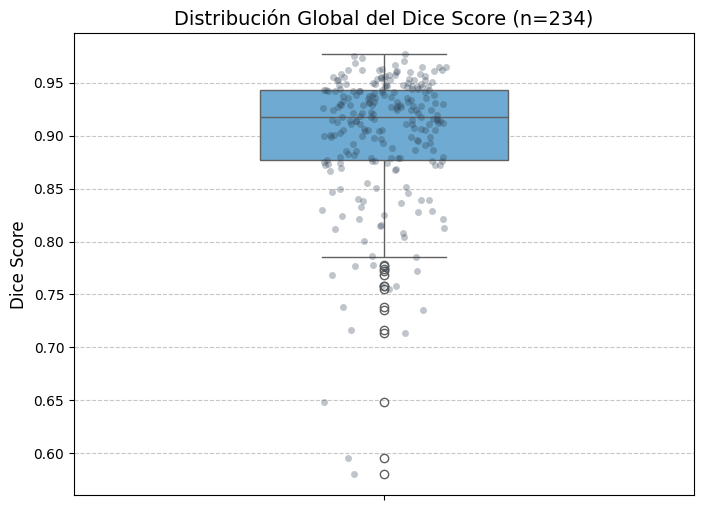

Mediana: 0.9174
Desviación Estándar: 0.0636


In [47]:
# DISTRIBUCIÓN ESTADÍSTICA Y BOXPLOT
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.boxplot(y=df['Dice_Score'], color='#5DADE2', width=0.4)
sns.stripplot(y=df['Dice_Score'], color='#2E4053', alpha=0.3, jitter=True) # Añado los puntos reales

plt.title("Distribución Global del Dice Score (n=234)", fontsize=14)
plt.ylabel("Dice Score", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.savefig(os.path.join(path_fotos, "boxplot_resultados.png"), dpi=150)
plt.show()

# Calculo la mediana y la desviación estándar para mi tabla de resultados.
print(f"Mediana: {df['Dice_Score'].median():.4f}")
print(f"Desviación Estándar: {df['Dice_Score'].std():.4f}")

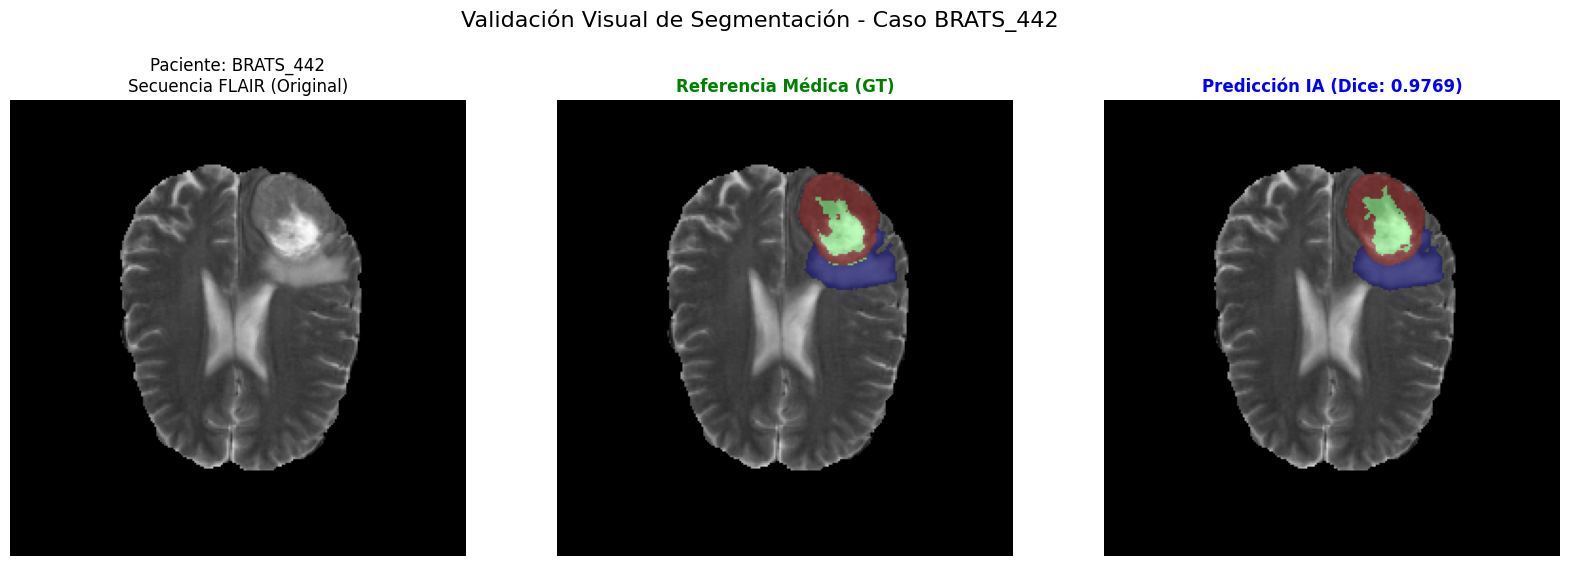

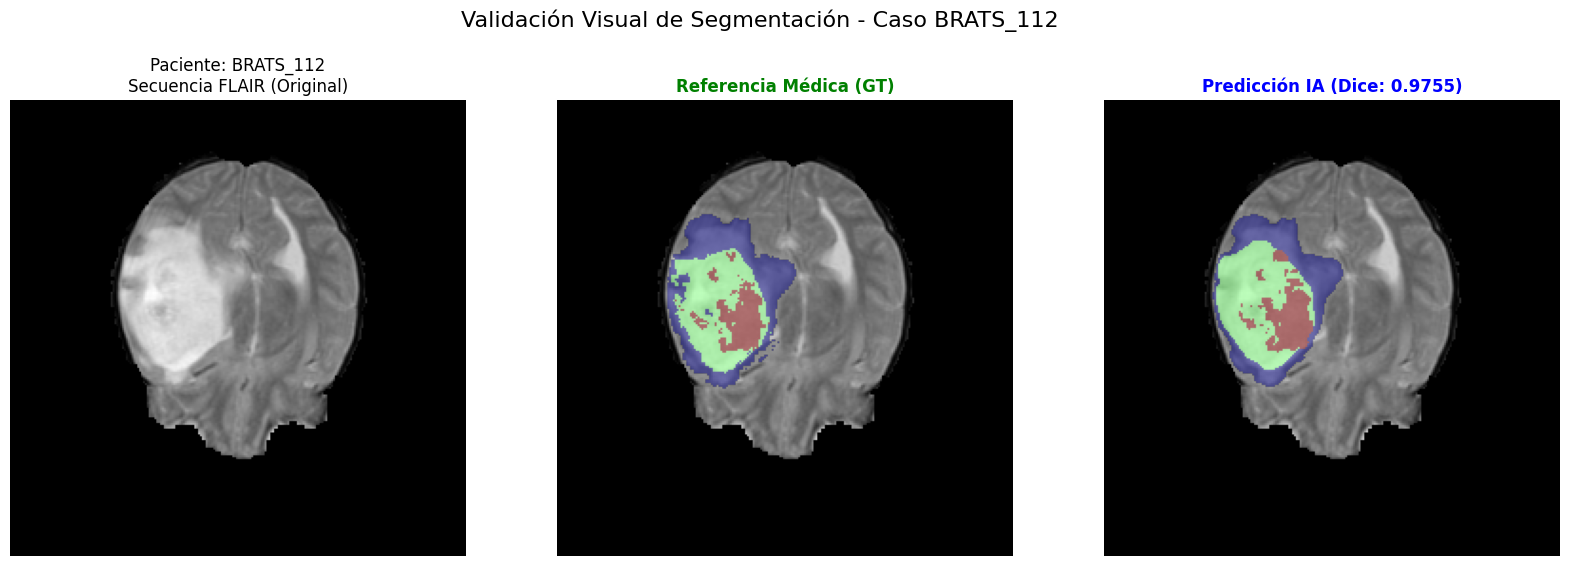

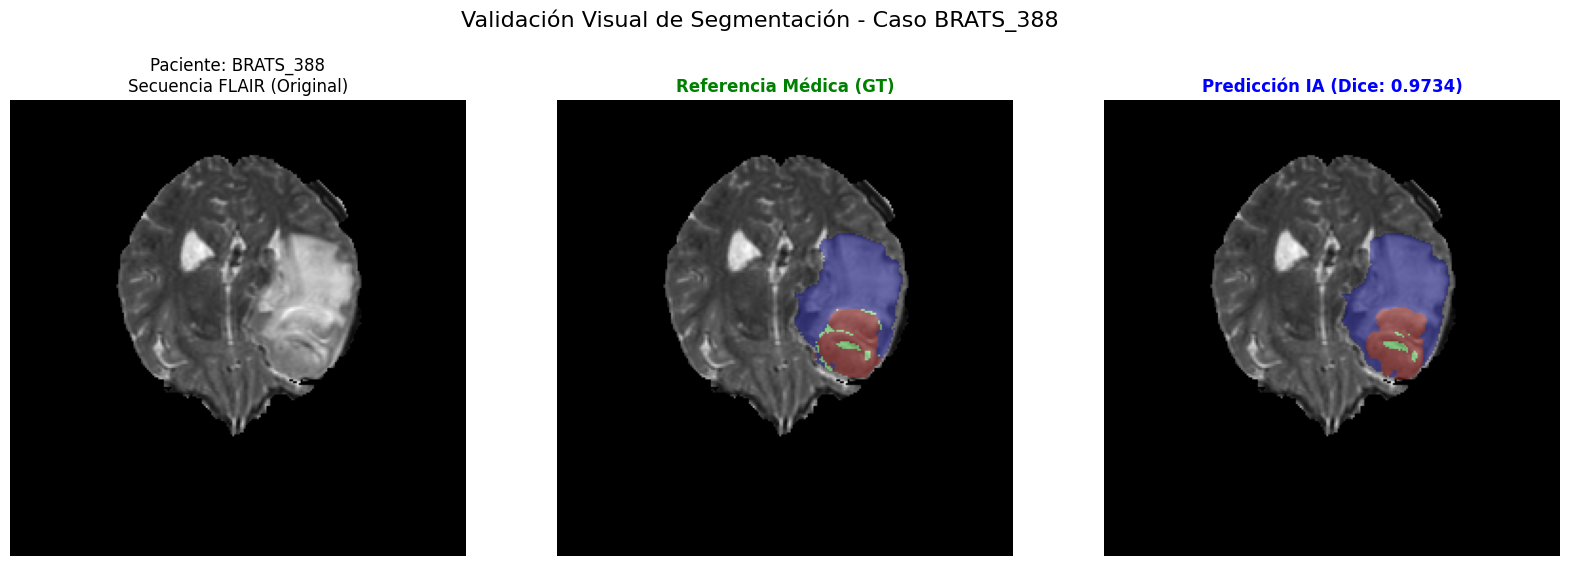

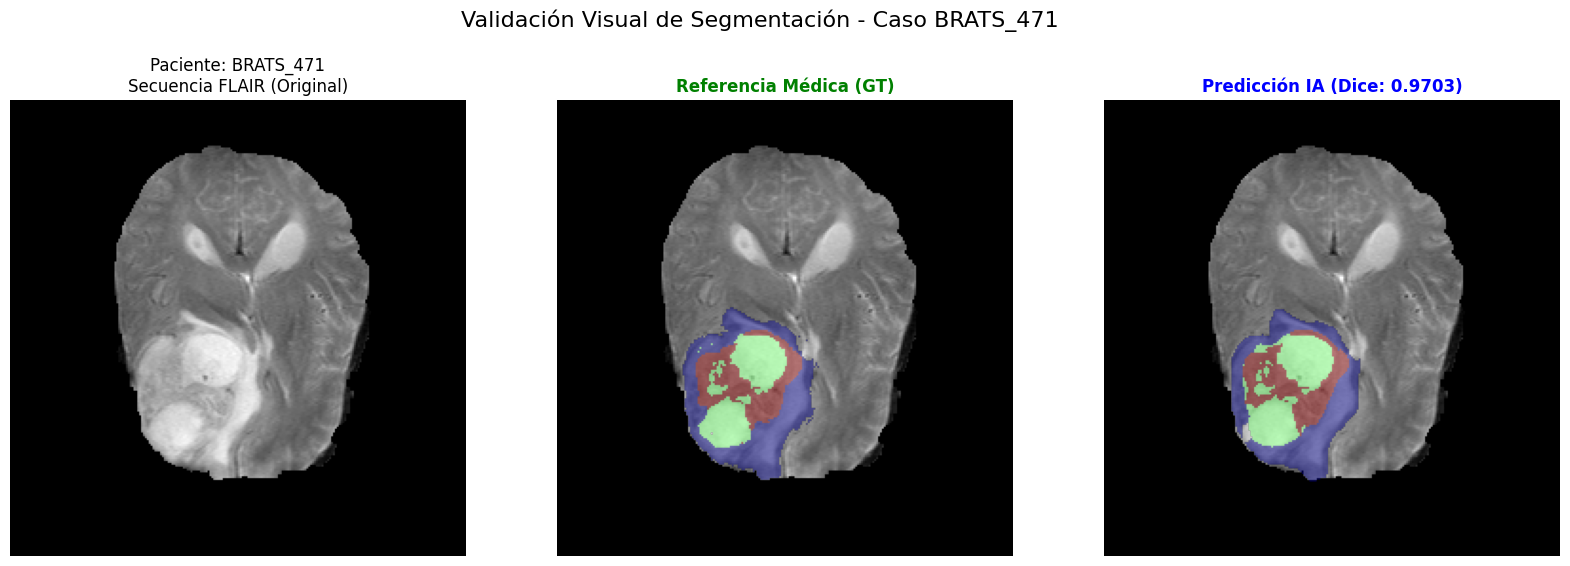

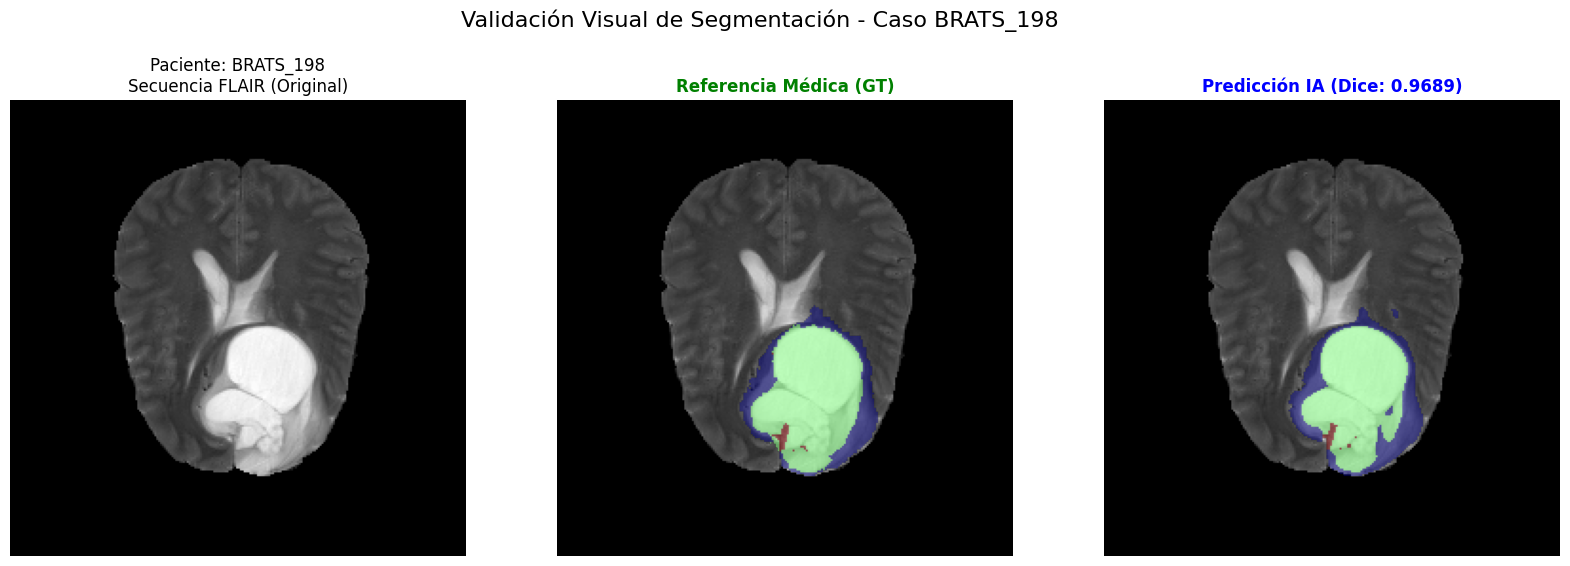

Las imágenes están listas en la carpeta: /content/tests/capturas_informe


In [38]:
#Visualización de la anatomía original con el criterio médico y la predicción.
path_fotos = "/content/tests/capturas_informe"
os.makedirs(path_fotos, exist_ok=True)

# Aislo los 5 mejores casos.
top_5_casos = df.sort_values(by="Dice_Score", ascending=False).head(5)

for index, row in top_5_casos.iterrows():
    # Extraigo el ID único y su puntuación específica para personalizar cada gráfico.
    pid = row['ID']
    score = row['Dice_Score']

    # Construyo las rutas absolutas.
    path_img_original = os.path.join(input_folder, f"{pid}_0003.nii.gz")
    path_mi_prediccion = os.path.join(path_pred, f"{pid}.nii.gz")
    path_verdad_medica = os.path.join(path_gt, f"{pid}.nii.gz")

    if os.path.exists(path_img_original) and os.path.exists(path_mi_prediccion):

        # Cargo los objetos NIfTI. Uso .get_fdata() para transformar los datos médicos comprimidos en matrices numéricas (NumPy arrays).
        vol_flair = nib.load(path_img_original).get_fdata()
        vol_gt = nib.load(path_verdad_medica).get_fdata()
        vol_pred = nib.load(path_mi_prediccion).get_fdata()

        # Buscar el plano óptimo (tumor más voluminoso):
        slice_idx = np.argmax(np.sum(vol_gt > 0, axis=(0, 1)))

        fig, ax = plt.subplots(1, 3, figsize=(20, 7), dpi=100)

        # Imagen anatómica
        ax[0].imshow(vol_flair[:, :, slice_idx].T, cmap='gray')
        ax[0].set_title(f"Paciente: {pid}\nSecuencia FLAIR (Original)", fontsize=12)
        ax[0].axis('off')

        # Referencia clínica
        # Uso un mapa de color 'jet' y una máscara booleana (np.ma.masked_where) para que el color solo aparezca sobre el tumor.
        ax[1].imshow(vol_flair[:, :, slice_idx].T, cmap='gray')
        mask_gt = np.ma.masked_where(vol_gt[:, :, slice_idx].T == 0, vol_gt[:, :, slice_idx].T)
        ax[1].imshow(mask_gt, cmap='jet', alpha=0.5)
        ax[1].set_title("Referencia Médica (GT)", fontsize=12, color='green', fontweight='bold')
        ax[1].axis('off')

        # Predicción del modelo
        ax[2].imshow(vol_flair[:, :, slice_idx].T, cmap='gray')
        mask_pred = np.ma.masked_where(vol_pred[:, :, slice_idx].T == 0, vol_pred[:, :, slice_idx].T)
        ax[2].imshow(mask_pred, cmap='jet', alpha=0.5)
        ax[2].set_title(f"Predicción IA (Dice: {score:.4f})", fontsize=12, color='blue', fontweight='bold')
        ax[2].axis('off')

        plt.suptitle(f"Validación Visual de Segmentación - Caso {pid}", fontsize=16, y=0.95)
        plt.savefig(os.path.join(path_fotos, f"TOP_5_comparativa_{pid}.png"), bbox_inches='tight')
        plt.show()

        plt.close(fig)

print(f"Las imágenes están listas en la carpeta: {path_fotos}")

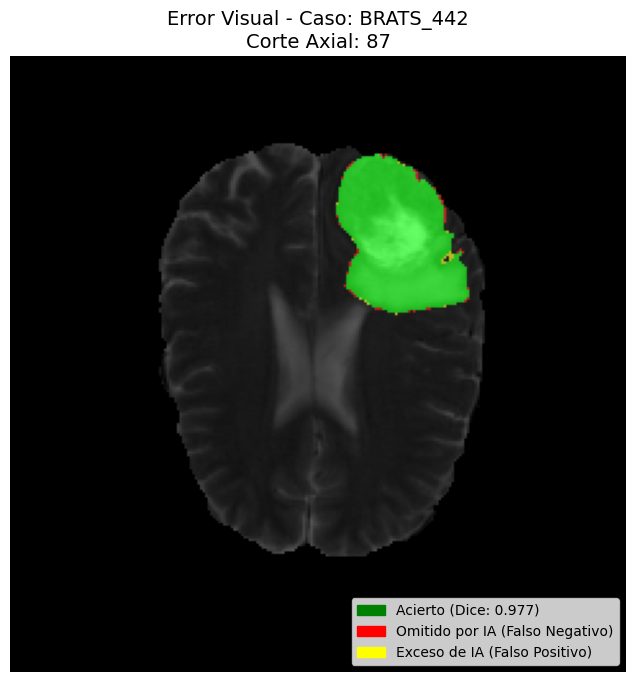

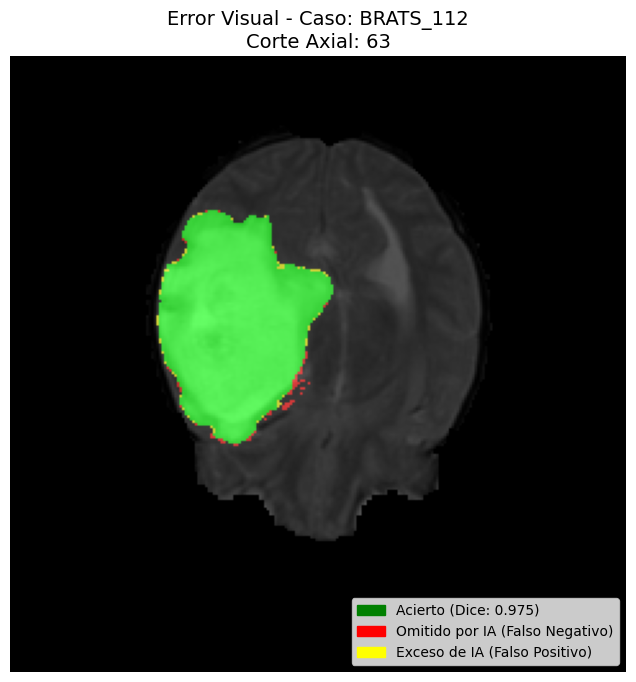

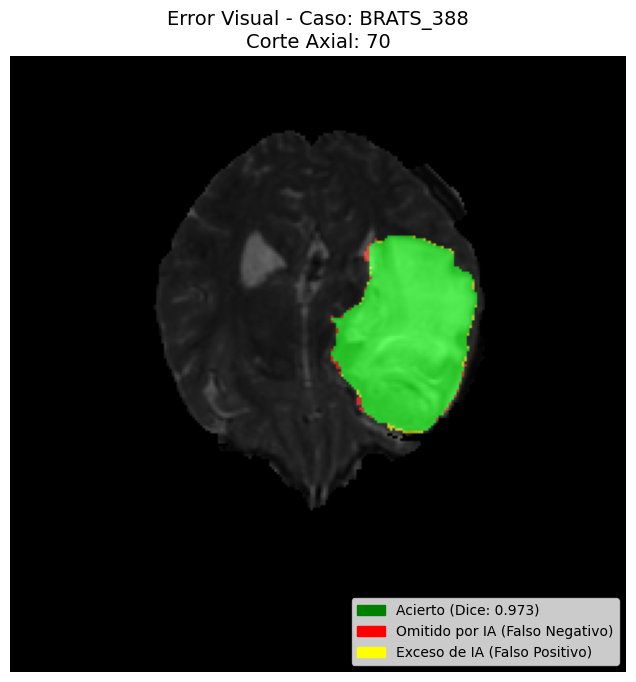

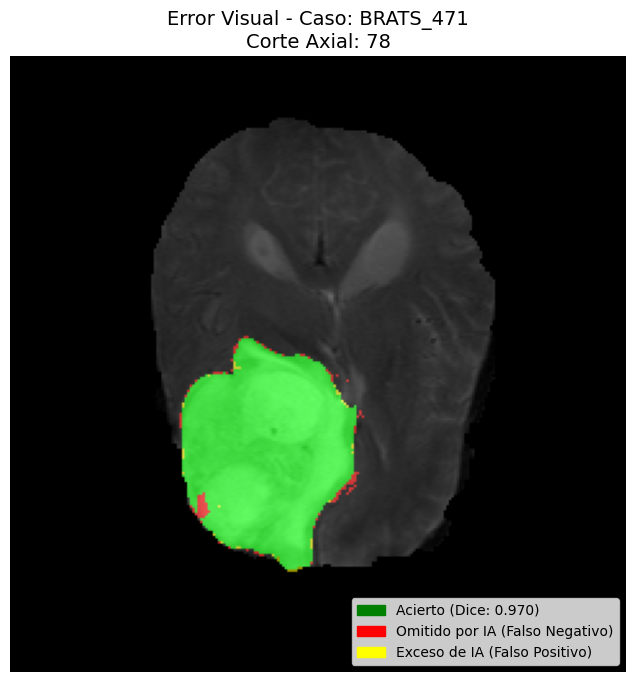

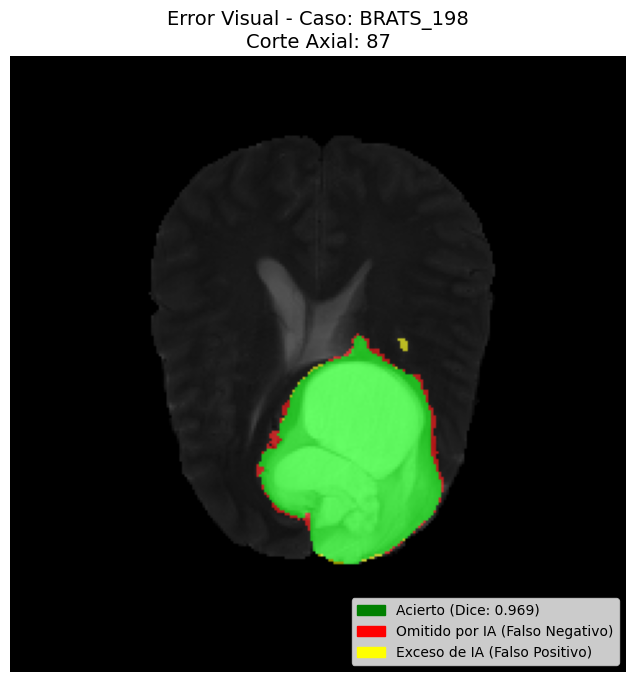

In [43]:
# VISUALIZACIÓN DEL ERROR

import matplotlib.patches as mpatches

# Utilizo otra vez los 5 mejores pacientes
for index, row in top_5_casos.iterrows():
    pid = row['ID']
    dice_val = row['Dice_Score']

    # Configuro las rutas para cargar la anatomía original y las máscaras.
    p_path = os.path.join(path_pred, f"{pid}.nii.gz")
    gt_path = os.path.join(path_gt, f"{pid}.nii.gz")
    img_path = os.path.join(input_folder, f"{pid}_0003.nii.gz") # Uso la secuencia FLAIR

    if os.path.exists(gt_path) and os.path.exists(img_path):
        # Cargo los volúmenes y binarizo las segmentaciones.
        vol_img = nib.load(img_path).get_fdata()
        vol_gt = (nib.load(gt_path).get_fdata() > 0).astype(int)
        vol_pred = (nib.load(p_path).get_fdata() > 0).astype(int)

        slice_idx = np.argmax(np.sum(vol_gt, axis=(0, 1)))

        # Cálculo del error
        # Determino matemáticamente las tres zonas críticas de la segmentación:
        tp = (vol_gt == 1) & (vol_pred == 1) # Acierto: los dos coinciden.
        fn = (vol_gt == 1) & (vol_pred == 0) # Falta (Rojo): el modelo no detectó esta zona.
        fp = (vol_gt == 0) & (vol_pred == 1) # Sobra (Amarillo): el modelo marcó tejido sano.

        # Construyo la matriz para el mapa de error del corte seleccionado.
        error_map = np.zeros((*vol_gt[:,:,slice_idx].shape, 3))
        error_map[tp[:,:,slice_idx]] = [0, 1, 0] # VERDE para el éxito.
        error_map[fn[:,:,slice_idx]] = [1, 0, 0] # ROJO para la omisión.
        error_map[fp[:,:,slice_idx]] = [1, 1, 0] # AMARILLO para la sobre-segmentación.

        error_map_plot = error_map.swapaxes(0, 1)

        mask_2d = np.sum(error_map_plot, axis=2) == 0
        mask_3d = np.stack([mask_2d] * 3, axis=-1)

        # Genero la visualización final superpuesta a la resonancia original.
        plt.figure(figsize=(12, 8), dpi=100)
        plt.imshow(vol_img[:,:,slice_idx].T, cmap='gray')

        plt.imshow(np.ma.masked_where(mask_3d, error_map_plot), alpha=0.6)

        patches = [
            mpatches.Patch(color='green', label=f'Acierto (Dice: {dice_val:.3f})'),
            mpatches.Patch(color='red', label='Omitido por IA (Falso Negativo)'),
            mpatches.Patch(color='yellow', label='Exceso de IA (Falso Positivo)')
        ]
        plt.legend(handles=patches, loc='lower right', frameon=True, facecolor='white')

        plt.title(f"Error Visual - Caso: {pid}\nCorte Axial: {slice_idx}", fontsize=14)
        plt.axis('off')

        plt.savefig(os.path.join(path_fotos, f"analisis_error_TOP_{pid}.png"), bbox_inches='tight')
        plt.show()
        plt.close()


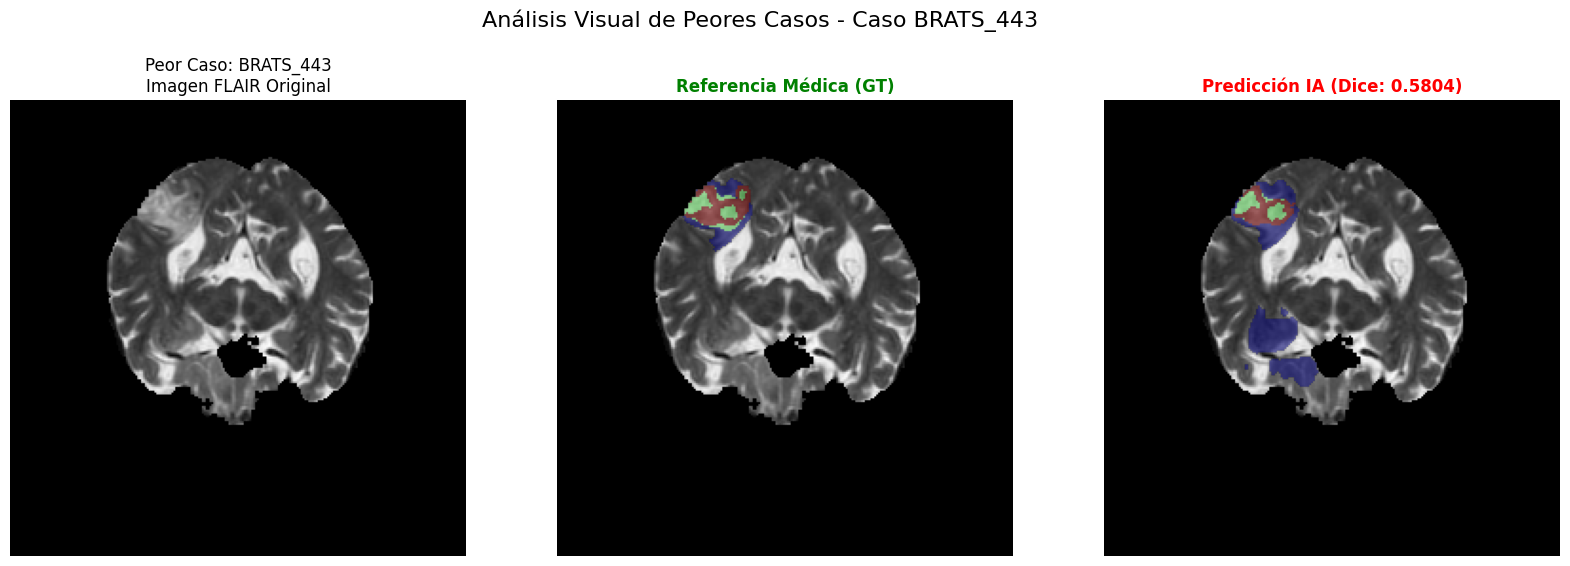

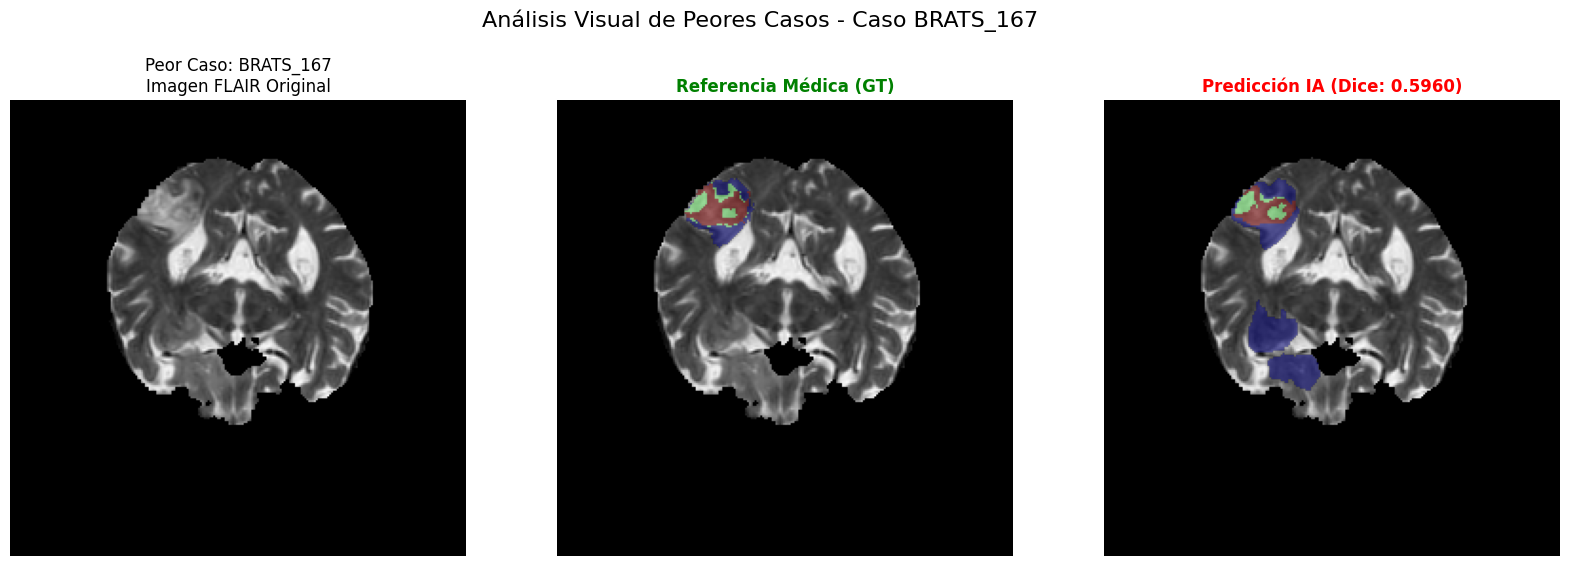

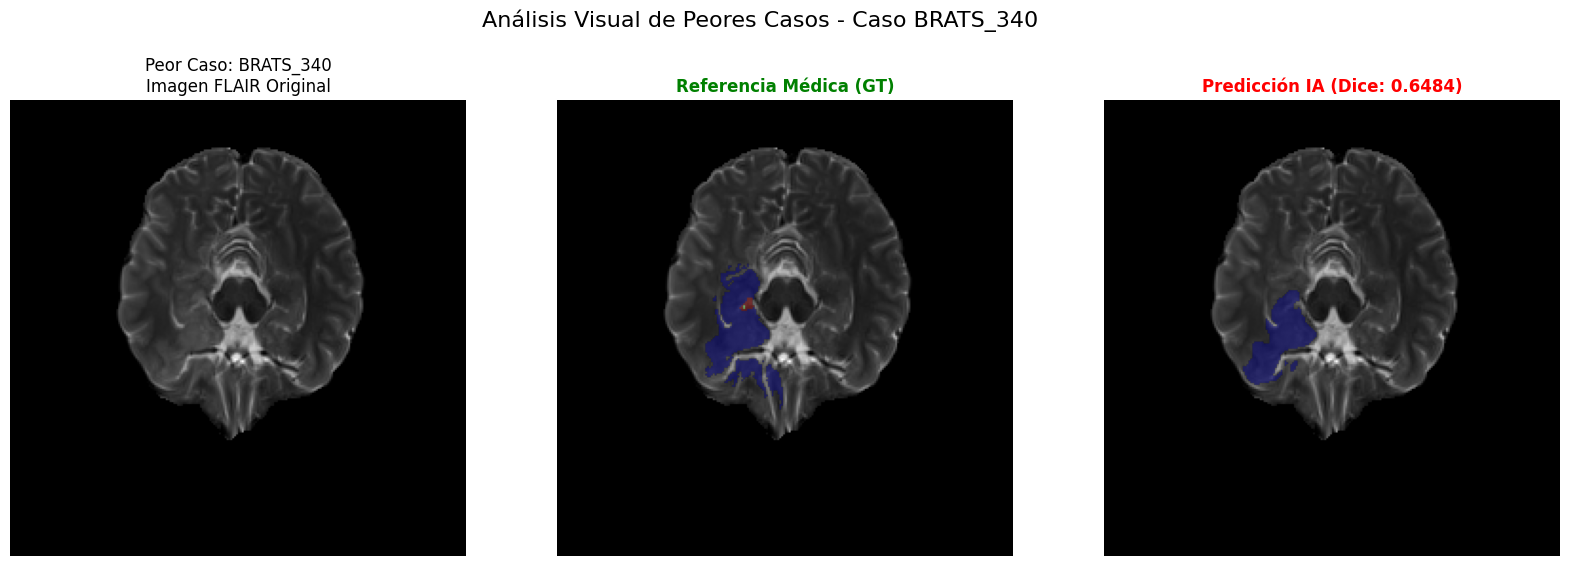

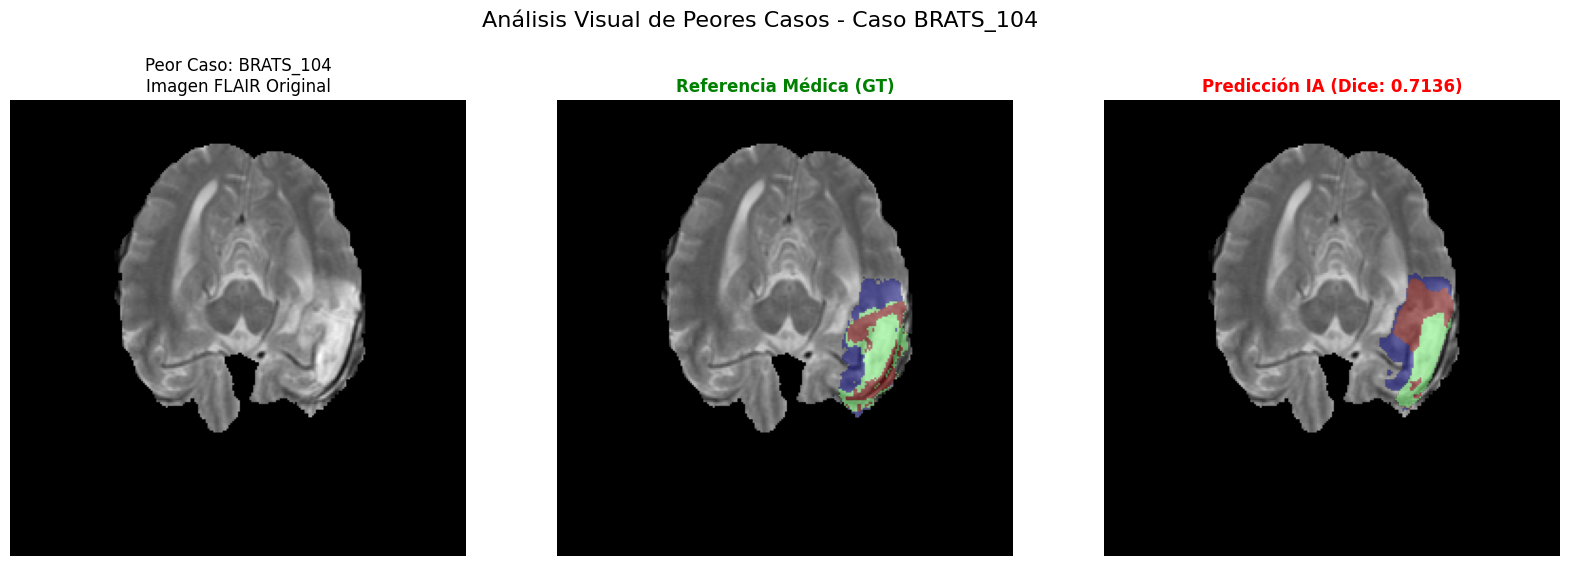

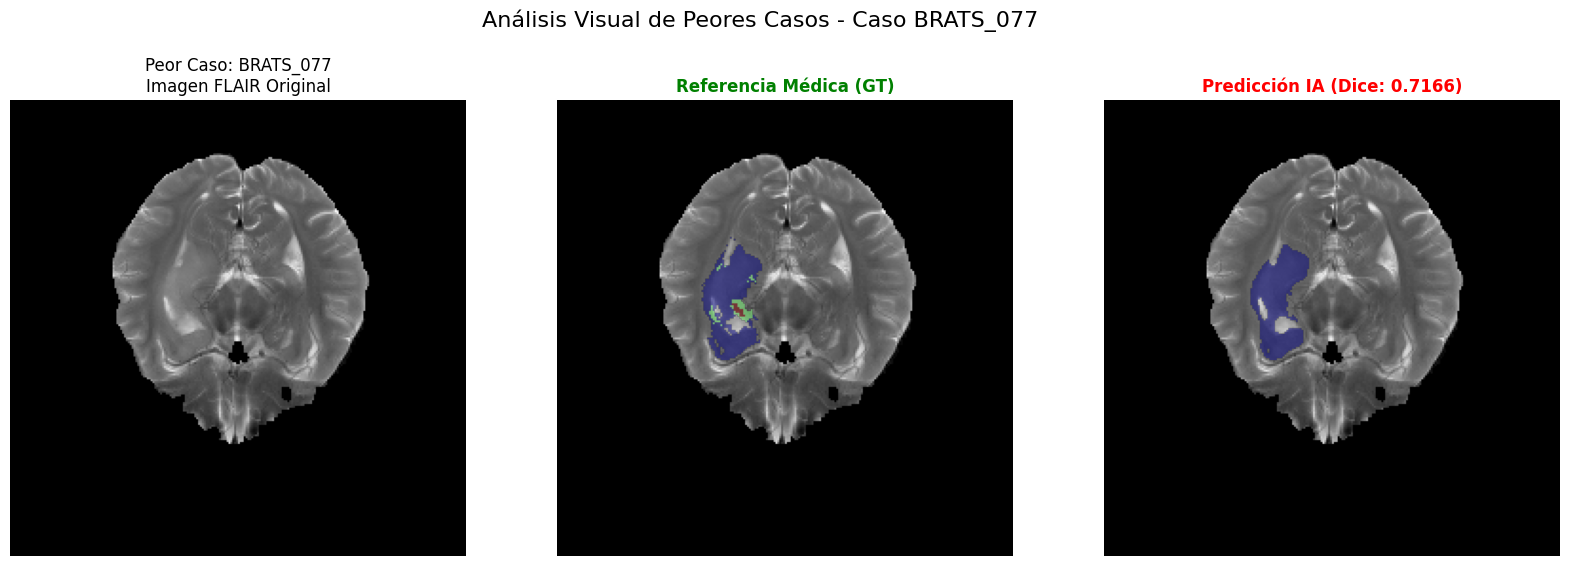

In [45]:
# ANÁLISIS VISUAL DE LOS ERRORES

path_fotos_errores = "/content/tests/capturas_informe_errores"
os.makedirs(path_fotos_errores, exist_ok=True)

# Extraigo los cinco peores casos
peores_5_casos = df.sort_values(by="Dice_Score", ascending=True).head(5)

for index, row in peores_5_casos.iterrows():
    # Recupero el ID del paciente y su puntuación baja para etiquetar el gráfico.
    pid = row['ID']
    score = row['Dice_Score']

    # Construyo las rutas.
    path_img_original = os.path.join(input_folder, f"{pid}_0003.nii.gz")
    path_mi_prediccion = os.path.join(path_pred, f"{pid}.nii.gz")
    path_verdad_medica = os.path.join(path_gt, f"{pid}.nii.gz")

    # Verificación de integridad de archivos antes de la carga de datos.
    if os.path.exists(path_img_original) and os.path.exists(path_mi_prediccion):

        # Cargo los volúmenes NIfTI y los convierto en matrices para su manipulación.
        vol_flair = nib.load(path_img_original).get_fdata()
        vol_gt = nib.load(path_verdad_medica).get_fdata()
        vol_pred = nib.load(path_mi_prediccion).get_fdata()

        slice_idx = np.argmax(np.sum(vol_gt > 0, axis=(0, 1)))

        fig, ax = plt.subplots(1, 3, figsize=(20, 7), dpi=100)

        # Imagen anatómica
        ax[0].imshow(vol_flair[:, :, slice_idx].T, cmap='gray')
        ax[0].set_title(f"Peor Caso: {pid}\nImagen FLAIR Original", fontsize=12)
        ax[0].axis('off')

        # Referencia médica
        ax[1].imshow(vol_flair[:, :, slice_idx].T, cmap='gray')
        mask_gt = np.ma.masked_where(vol_gt[:, :, slice_idx].T == 0, vol_gt[:, :, slice_idx].T)
        ax[1].imshow(mask_gt, cmap='jet', alpha=0.5)
        ax[1].set_title("Referencia Médica (GT)", fontsize=12, color='green', fontweight='bold')
        ax[1].axis('off')

        # Predicción
        ax[2].imshow(vol_flair[:, :, slice_idx].T, cmap='gray')
        mask_pred = np.ma.masked_where(vol_pred[:, :, slice_idx].T == 0, vol_pred[:, :, slice_idx].T)
        ax[2].imshow(mask_pred, cmap='jet', alpha=0.5)
        ax[2].set_title(f"Predicción IA (Dice: {score:.4f})", fontsize=12, color='red', fontweight='bold')
        ax[2].axis('off')

        plt.suptitle(f"Análisis Visual de Peores Casos - Caso {pid}", fontsize=16, y=0.95)
        plt.savefig(os.path.join(path_fotos_errores, f"ERROR_PEOR_5_{pid}.png"), bbox_inches='tight')
        plt.show()

        plt.close(fig)

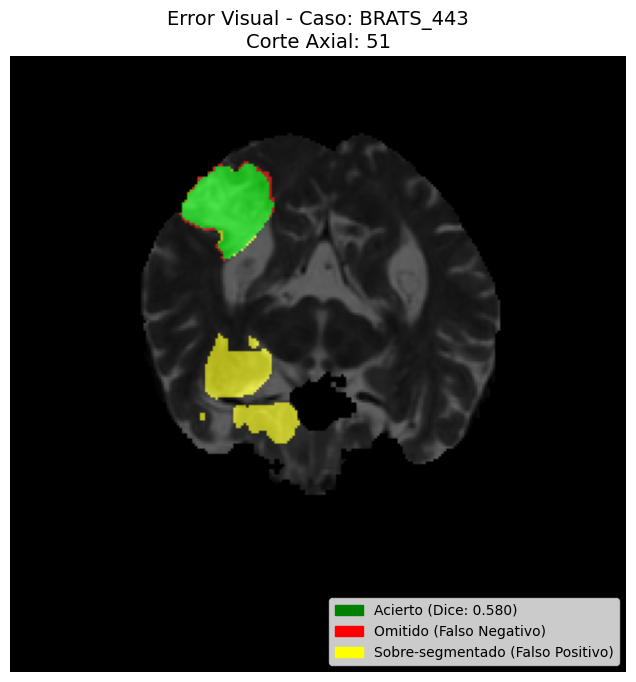

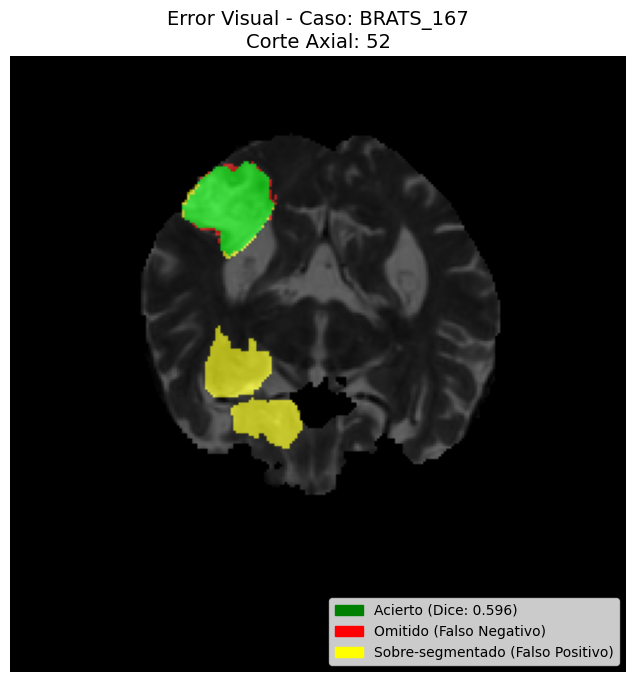

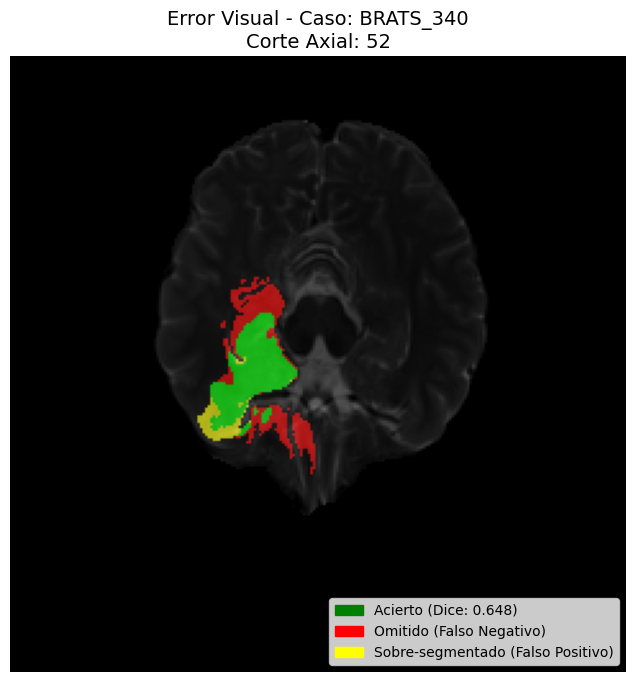

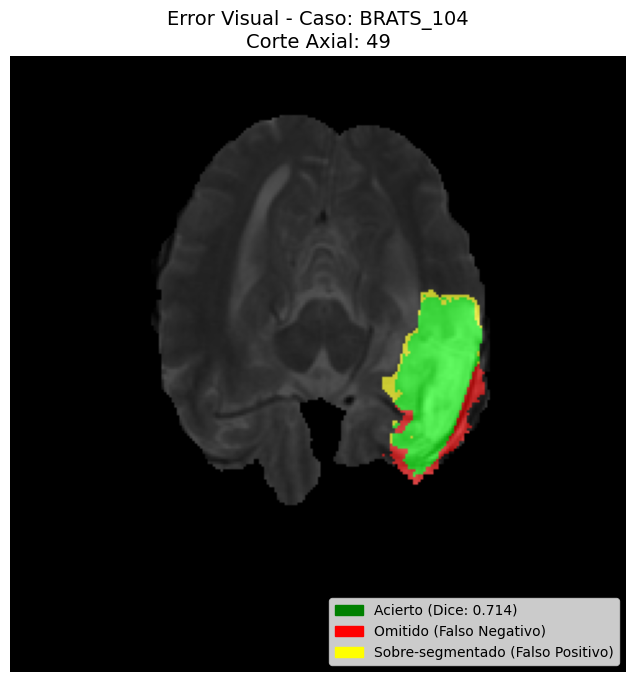

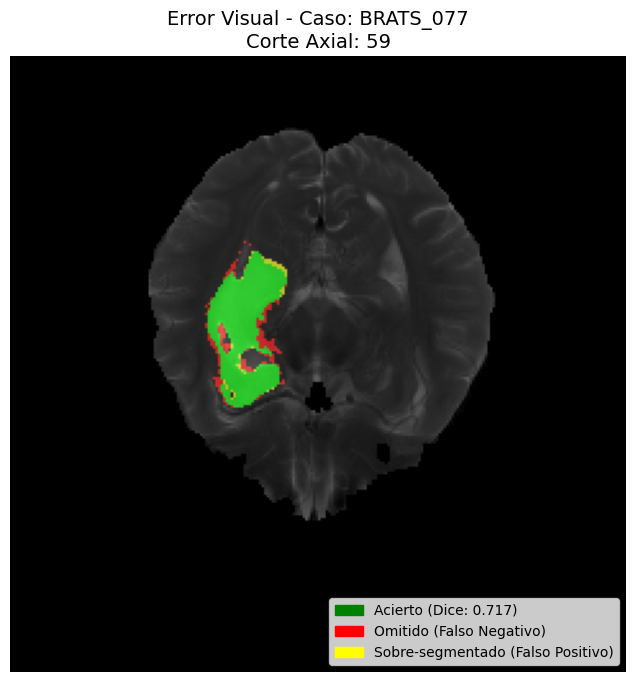

In [46]:
# ERROR VISUAL PEORES CASOS

# Utilizo otra vez los 5 peores casos
for index, row in peores_5_casos.iterrows():
    pid = row['ID']
    dice_val = row['Dice_Score']

    p_path = os.path.join(path_pred, f"{pid}.nii.gz")
    gt_path = os.path.join(path_gt, f"{pid}.nii.gz")
    img_path = os.path.join(input_folder, f"{pid}_0003.nii.gz")

    if os.path.exists(gt_path) and os.path.exists(img_path):
        vol_img = nib.load(img_path).get_fdata()
        vol_gt = (nib.load(gt_path).get_fdata() > 0).astype(int)
        vol_pred = (nib.load(p_path).get_fdata() > 0).astype(int)

        slice_idx = np.argmax(np.sum(vol_gt, axis=(0, 1)))

        tp = (vol_gt == 1) & (vol_pred == 1)
        fn = (vol_gt == 1) & (vol_pred == 0)
        fp = (vol_gt == 0) & (vol_pred == 1)

        error_map = np.zeros((*vol_gt[:,:,slice_idx].shape, 3))
        error_map[tp[:,:,slice_idx]] = [0, 1, 0]
        error_map[fn[:,:,slice_idx]] = [1, 0, 0]
        error_map[fp[:,:,slice_idx]] = [1, 1, 0]

        error_map_plot = error_map.swapaxes(0, 1)
        mask_2d = np.sum(error_map_plot, axis=2) == 0
        mask_3d = np.stack([mask_2d] * 3, axis=-1)

        plt.figure(figsize=(12, 8), dpi=100)
        plt.imshow(vol_img[:,:,slice_idx].T, cmap='gray')

        plt.imshow(np.ma.masked_where(mask_3d, error_map_plot), alpha=0.6)

        patches = [
            mpatches.Patch(color='green', label=f'Acierto (Dice: {dice_val:.3f})'),
            mpatches.Patch(color='red', label='Omitido (Falso Negativo)'),
            mpatches.Patch(color='yellow', label='Sobre-segmentado (Falso Positivo)')
        ]
        plt.legend(handles=patches, loc='lower right', frameon=True, facecolor='white')

        plt.title(f"Error Visual - Caso: {pid}\nCorte Axial: {slice_idx}", fontsize=14)
        plt.axis('off')

        plt.savefig(os.path.join(path_fotos, f"analisis_error_PEOR_{pid}.png"), bbox_inches='tight')
        plt.show()
        plt.close()

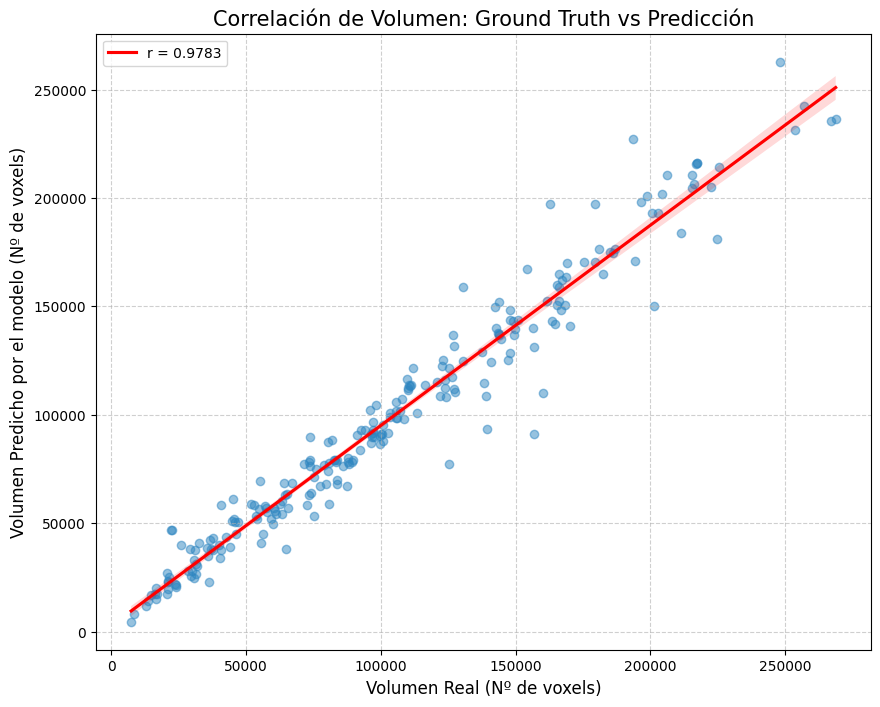


Coeficiente de correlación (r): 0.9783
La significancia estadística (p-value) es de: 1.47e-160


In [49]:
# ANÁLISIS DE PREDICCIÓN DEL VOLUMEN

from scipy.stats import pearsonr

vol_real = []
vol_predicho = []

# Recorro de nuevo mis archivos para extraer el recuento total de voxels.
for p_path in pred_files:
    pid = os.path.basename(p_path).replace(".nii.gz", "")
    gt_path = os.path.join(path_gt, f"{pid}.nii.gz")

    if os.path.exists(gt_path):
        # Cargo los datos binarizados para contar solo los voxels del tumor.
        data_gt = nib.load(gt_path).get_fdata() > 0
        data_pred = nib.load(p_path).get_fdata() > 0

        # Sumo el total de voxels activos.
        vol_real.append(np.sum(data_gt))
        vol_predicho.append(np.sum(data_pred))

# Calculo el Coeficiente de Correlación de Pearson (r).
r, p_val = pearsonr(vol_real, vol_predicho)

plt.figure(figsize=(10, 8))
sns.regplot(x=vol_real, y=vol_predicho,
            scatter_kws={'alpha':0.5, 'color':'#2E86C1'},
            line_kws={'color':'red', 'label':f'r = {r:.4f}'})

plt.title("Correlación de Volumen: Ground Truth vs Predicción", fontsize=15)
plt.xlabel("Volumen Real (Nº de voxels)", fontsize=12)
plt.ylabel("Volumen Predicho por el modelo (Nº de voxels)", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.savefig(os.path.join(path_fotos, "correlacion_volumen.png"), dpi=150)
plt.show()

print(f"\nCoeficiente de correlación (r): {r:.4f}")
print(f"La significancia estadística (p-value) es de: {p_val:.2e}")

In [50]:
# CÁLCULO DE LA DISTANCIA DE HAUSDORFF (HD95)
# El HD95 para medir el error máximo de los bordes en milímetros.
# Esta métrica asegura que el modelo no se aleje demasiado de los márgenes reales.

# Instalo la librería necesaria para el cálculo de distancias en volúmenes 3D.
!pip install MedPy --quiet

from medpy import metric

# Recupero mi lista de resultados previos para añadirle la nueva columna de HD95.
hd95_list = []

for p_path in pred_files:
    pid = os.path.basename(p_path).replace(".nii.gz", "")
    gt_path = os.path.join(path_gt, f"{pid}.nii.gz")

    if os.path.exists(gt_path):
        # Cargo los volúmenes NIfTI.
        obj_pred = nib.load(p_path)
        obj_gt = nib.load(gt_path)

        # Binarizo.
        data_pred = (obj_pred.get_fdata() > 0).astype(int)
        data_gt = (obj_gt.get_fdata() > 0).astype(int)

        spacing = obj_gt.header.get_zooms()

        try:
            # Si los dos coinciden, calculo la distancia.
            if np.sum(data_pred) > 0 and np.sum(data_gt) > 0:
                dist = metric.binary.hd95(data_pred, data_gt, voxelspacing=spacing)
            else:
                # Si uno de los dos no tiene tumor, la distancia no es calculable (infinito).
                dist = np.nan
        except:
            dist = np.nan

        hd95_list.append(dist)

df['HD95_mm'] = hd95_list
df.to_csv(ruta_csv, index=False)

print(f"HD95 MEDIO DEL MODELO: {df['HD95_mm'].dropna().mean():.4f} mm")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.3/156.3 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
HD95 MEDIO DEL MODELO: 5.9699 mm
